# Reduces Device Memory Usage by Dividing and Stitching the Wavenumber Grid ($\nu$ - stitching)

Here, we explain the method of reducing GPU device memory usage by dividing the wavenumber grid ($\nu$ - stitching). 
This approach is particularly effective for transmission spectroscopy, 
where [opart](get_started_opart.html) cannot be used. 
When applying this method, [forward-mode differentiation](get_started_opart.html#optimization-of-opart-using-forward-differentiation) should be used for derivatives. While $\nu$ - stitching [can be performed manually](Open_Close_Cross_Section.html), we describe the procedure using `opastitch` in this section.

Currently, the only opacity calculator that supports $\nu$-stitching is PreMODIT (v2.0), which can be used with `OpaPremodit`.

In [ ]:
from exojax.spec.opacalc import OpaPremodit
from exojax.utils.grids import wavenumber_grid
from exojax.spec.api import MdbExomol
from exojax.spec.atmrt import ArtTransPure
import jax.numpy as jnp


from jax import config 
config.update("jax_enable_x64", True)


/home/kawahara/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


In this example, the OH molecule is used to compute opacity over the 1.7–2.3 micron range, divided into 300,000 segments, with 200 atmospheric layers. At the time of creating this notebook, the computation was performed on a gaming laptop with 8GB of device memory.

In [2]:
N=300000
nus, wav, res = wavenumber_grid(17000.0, 23000.0, N, unit="AA", xsmode="premodit")
print("resolution=",res)
mdb = MdbExomol(".database/OH/16O-1H/MoLLIST/", nus)


/home/kawahara/exojax/src/exojax/spec/unitconvert.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
Your wavelength grid is in ***  descending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.
resolution= 992451.1535950146
HITRAN exact name= (16O)H
radis engine =  vaex
Molecule:  OH
Isotopologue:  16O-1H
ExoMol database:  None
Local folder:  .database/OH/16O-1H/MoLLIST
Transition files: 
	 => File 16O-1H__MoLLIST.trans
Broadener:  H2
The default broadening parameters are used.


/home/kawahara/anaconda3/lib/python3.10/site-packages/radis-0.16-py3.10.egg/radis/api/exomolapi.py:1527: UserWarning: Could not load `16O-1H__H2.broad`. The default broadening parameters are used.

  warnings.warn(


In [ ]:
art = ArtTransPure(pressure_top=1.e-15, pressure_btm=1.e1, nlayer=300) #300 OK
Tarr = jnp.ones_like(art.pressure)*3000.0
Parr = art.pressure

integration:  simpson
Simpson integration, uses the chord optical depth at the lower boundary and midppoint of the layers.


/home/kawahara/exojax/src/exojax/spec/atmrt.py:53: UserWarning: nu_grid is not given. specify nu_grid when using 'run' 
  warnings.warn(


In [4]:
ndiv=20
opas = OpaPremodit(mdb, nus, nstitch=ndiv, auto_trange=[500,1300], cutwing = 0.015)
xsm_s = opas.xsmatrix(Tarr, Parr)


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.7803992045456 - 1334.4906506037173 K
OpaPremodit: Tref_broadening is set to  806.2257748298548 K
# of reference width grid :  4
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 3776.95it/s]

Premodit: Twt= 1049.0651485510987 K Tref= 539.7840596059918 K
Making LSD:|####################| 100%


OpaPremodit: Stitching mode is used: nstitch = 20
cross section is calculated in the stitching mode.
wing cut width =  [19.66940912454993, 26.732490348052124] cm-1


2025-03-01 11:22:51.517393: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 3.15GiB (3379083196 bytes) by rematerialization; only reduced to 3.52GiB (3775929320 bytes), down from 3.52GiB (3775948936 bytes) originally


You can check the wing-cut wavenumber $\Delta \nu \sim 20$ cm-1.

In [5]:
print(xsm_s.shape), mdb.molmass

(300, 300000)


(None, 17.00274)

In [6]:
from exojax.utils.astrofunc import gravity_jupiter
mmr = jnp.ones_like(Parr)*0.01
g = gravity_jupiter(1.0,1.0)
dtau = art.opacity_profile_xs(xsm_s,mmr,mdb.molmass,g)

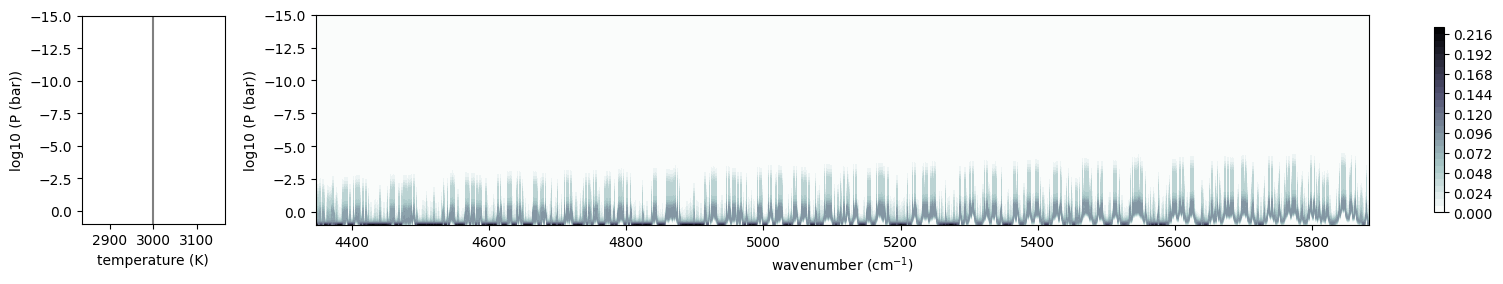

In [7]:
from exojax.plot.atmplot import plotcf
cf = plotcf(nus, dtau, Tarr, Parr, art.dParr)

In [8]:
from exojax.utils.constants import RJ
mmw = jnp.ones_like(Parr)*2.0
r2 = art.run(dtau, Tarr, mmw, RJ, g)

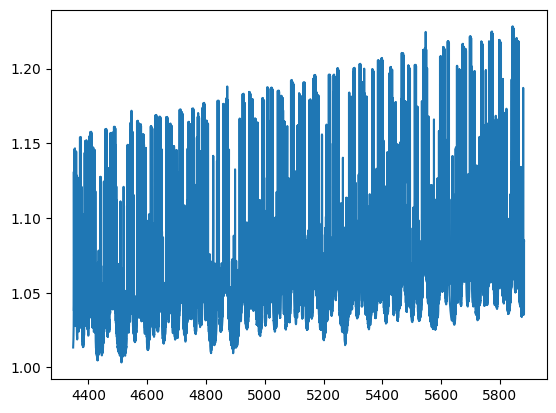

In [10]:
import matplotlib.pyplot as plt
plt.plot(nus, r2)